<h3>Loading dataset</h3>

In [2]:
import pandas as pd
import numpy as np

# import csv
df = pd.read_csv('modified_dataset.csv', 
                 dtype={'Temperature':str, 
                        'Pressure0':str, 
                        'Humidity':str, 
                        'Wind_speed':str}, 
                 delimiter=';', 
                 na_filter=False)
df.head()

,Time,Temperature,Pressure0,Pressure,Humidity,Wind_speed,mist,Unnamed: 7,snow,rain,...,Wind_direction_variable,Wind_direction_west,Wind_direction_west-northwest,Wind_direction_west-southwest,Cloud_,Cloud_broken clouds,Cloud_few clouds,Cloud_no significant clouds,Cloud_overcast,Cloud_scattered clouds
0,1420070400,-12,762.5,777.7,85,2,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1,1420072200,-11,761.9,777.0,85,1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1420074000,-10,761.9,777.0,85,1,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,1420075800,-10,761.9,777.0,85,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1420077600,-9,762,777.0,79,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


<h3>Preparing input and output sequence</h3>

In [ ]:
t=[1, 2, 3, 4, ]

In [61]:
X = np.array(df.loc[:,(df.columns != 'Time')].values)
Y = np.array(df['Temperature'])
print(X.shape)
X = X[0:63134,:]
print(X)
Y = X[1:63135,0]

(63135, 40)
[['-12' '762.5' 777.7 ... 1 0 0]
 ['-11' '761.9' 777.0 ... 1 0 0]
 ['-10' '761.9' 777.0 ... 1 0 0]
 ...
 ['5' '754' 768.1 ... 0 1 0]
 ['5' '754' 768.1 ... 0 0 0]
 ['5' '754' 768.1 ... 0 0 0]]


In [62]:
for idx, val in enumerate(X[:,0]):
    if val=='':
        X[:,0][idx] = (np.float64(X[:,0][idx-1])+np.float64(X[:,0][idx+1]))/2
    else:
        X[:,0][idx] = np.float64(val)
        
for idx, val in enumerate(X[:,1]):
    if val=='':
        X[:,1][idx] = (np.float64(X[:,1][idx-1])+np.float64(X[:,1][idx+1]))/2
    else:
        X[:,1][idx] = np.float64(val)
        

for idx, val in enumerate(X[:,2]):
    if val=='':
        X[:,2][idx] = (int(X[:,2][idx-1])+int(X[:,2][idx+1]))/2
    else:
        X[:,2][idx] = int(val)
        
for idx, val in enumerate(X[:,3]):
    if val=='':
        X[:,3][idx] = (int(X[:,3][idx-1])+int(X[:,3][idx+1]))/2
    else:
        X[:,3][idx] = int(val)
        
for idx, val in enumerate(X[:,4]):
    if val=='':
        X[:,4][idx] = (int(X[:,4][idx-1])+int(X[:,4][idx+1]))/2
    else:
        X[:,4][idx] = int(val)
        
for idx, val in enumerate(Y):
    if val=='':
        Y[idx] = (int(Y[idx-1])+int(Y[idx+1]))/2
    else:
        Y[idx] = int(val)

print(Y.shape)
Y2=np.zeros((63132,2), dtype='float64')
Y2[0:63132, 1] = Y[0:63132]
Y2[0:63132, 0] = Y[1:63133]

X2 = X[1:63133,:]

X=X2
Y=Y2



(63133,)


In [63]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Activation, Dense, Flatten
from tensorflow.python.keras.layers import GRU
from keras.optimizers import SGD, Adam
from keras.wrappers import scikit_learn
from keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from keras.layers import LSTM

<h3>Preprocessing data</h3>

In [64]:
nb_samples = len(X)
test_split = 0.2
# splitting train-validation-test sets
X_train = X[0:int(nb_samples*(1-test_split))]
Y_train = Y[0:int(nb_samples*(1-test_split))]
X_test  = X[int(nb_samples*(1-test_split)):]
Y_test  = Y[int(nb_samples*(1-test_split)):]

# standardizing
scaler = preprocessing.StandardScaler().fit(X_train)

from sklearn.externals import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 

X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

print(X_train.shape)
print(Y_train.shape)

print(np.std(X_train, 1))
print(np.mean(X_train,1))

C:\Users\admin\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(50505, 40)
(50505, 2)
[0.87478873 0.86853484 1.26221337 ... 1.07783103 1.03086899 1.01981623]
[-0.02750555 -0.02493609  0.06683645 ... -0.06654716 -0.09772546
 -0.10679683]


<h3>Loss function definition</h3>

In [65]:
import keras.backend as K
#print(np.max(Y_train[0:,0]-Y_train[0:,1]))

def vori(y_true, y_pred):
    mse= K.square(K.tf.subtract(y_true[:,0], y_pred))
    constr = K.maximum(K.tf.subtract(K.abs(K.tf.subtract(y_true[:,1], y_pred)),
                     K.constant(value=12.0, dtype = 'float32')),
                     K.constant(value= 0.0, dtype = 'float32'))
    return(K.mean(mse+constr))


def nemvori(y_true, y_pred):
    mse= K.square(K.tf.subtract(y_true[:,0], y_pred))
    return(K.mean(mse))
#regm.compile(optimizer=adam, loss=[AAD_loss(1.0)], metrics=['accuracy']) 

<h3>Model definition</h3>

In [66]:
# def modelfn(constrain=True):
    
#     def modelbuilder():
#         model = Sequential()
#         model.add(Dense(4, input_dim=40, activation='relu'))
#         model.add(Dense(2, activation='relu'))
#         model.add(Dense(1, activation='linear'))
#         if(constraint):
#             model.compile(loss=vori, optimizer='adam')
#         else:
#             model.compile(loss='mse', optimizer='adam')
#         return model
    
#     return modelbuilder
# ctrestimator = KerasRegressor(build_fn=[modelfn(True)], epochs=10, batch_size=16,verbose=1)
# history = ctrestimator.fit(X_train, Y_train)

In [67]:
adam=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

def modelctr():
    model = Sequential()    
    model.add(Dense(1, input_dim=1, activation='linear'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=vori, optimizer=adam)
    return model

def modelnoctr():
    model = Sequential()    
    model.add(Dense(4, input_dim=40, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=nemvori, optimizer=adam)
    return model

In [68]:
# def modelctr():
#     model = Sequential()    
#     model.add(Dense(8, input_dim=40, activation='relu'))
#     model.add(Dense(4, activation='relu'))
#     model.add(Dense(2, activation='linear'))
#     model.compile(loss=vori, optimizer='adam')
#     print(model.summary())
#     return model

# def modelnoctr():
#     model = Sequential()    
#     model.add(Dense(4, input_dim=40, activation='relu'))
#     model.add(Dense(2, activation='linear'))
#     model.compile(loss=nemvori, optimizer='adam')
#     return model

<h3> Training </h3>

In [69]:
print(X_train.shape, '\n', Y_train.shape)
ctrestimator = KerasRegressor(build_fn=modelctr, epochs=15, batch_size=16,verbose=1)
ctrhistory = ctrestimator.fit(X_train[:,0], Y_train)

(50505, 40) 
 (50505, 2)
Epoch 1/15
50505/50505 [==============================] - 6s 116us/step - loss: 135.5939
Epoch 2/15
50505/50505 [==============================] - 5s 95us/step - loss: 95.1883
Epoch 3/15
50505/50505 [==============================] - 5s 99us/step - loss: 95.2114
Epoch 4/15
50505/50505 [==============================] - 5s 99us/step - loss: 95.1963
Epoch 5/15
50505/50505 [==============================] - 5s 98us/step - loss: 95.2163
Epoch 6/15
50505/50505 [==============================] - 5s 96us/step - loss: 95.1914
Epoch 7/15
50505/50505 [==============================] - 5s 102us/step - loss: 95.2162
Epoch 8/15
50505/50505 [==============================] - 5s 96us/step - loss: 95.1707
Epoch 9/15
50505/50505 [==============================] - 5s 97us/step - loss: 95.1785
Epoch 10/15
50505/50505 [==============================] - 5s 101us/step - loss: 95.2093
Epoch 11/15
50505/50505 [==============================] - 5s 96us/step - loss: 95.2087
Epoch 12/15


In [12]:
estimator = KerasRegressor(build_fn=modelnoctr, epochs=15, batch_size=16,verbose=1)
history = estimator.fit(X_train, Y_train)

Epoch 1/15
50506/50506 [==============================] - 5s 89us/step - loss: 174.9028
Epoch 2/15
50506/50506 [==============================] - 4s 83us/step - loss: 133.3374
Epoch 3/15
50506/50506 [==============================] - 4s 87us/step - loss: 108.8064
Epoch 4/15
50506/50506 [==============================] - 4s 82us/step - loss: 97.9775
Epoch 5/15
50506/50506 [==============================] - 4s 83us/step - loss: 95.0837
Epoch 6/15
50506/50506 [==============================] - 4s 88us/step - loss: 94.6947
Epoch 7/15
50506/50506 [==============================] - 4s 83us/step - loss: 94.6615
Epoch 8/15
50506/50506 [==============================] - 4s 83us/step - loss: 94.6581
Epoch 9/15
50506/50506 [==============================] - 4s 83us/step - loss: 94.6584
Epoch 10/15
50506/50506 [==============================] - 4s 87us/step - loss: 94.6580
Epoch 11/15
50506/50506 [==============================] - 4s 83us/step - loss: 94.6587
Epoch 12/15
50506/50506 [=============

In [13]:
ctrestimator.model.save('saved_constrained_model.h5')
estimator.model.save('saved_model.h5')

<h3>Predicting</h3>

In [34]:
predctr=ctrestimator.predict(X_test)
pred = estimator.predict(X_test)

12627/12627 [==============================] - 1s 40us/step


In [37]:
predctr=ctrestimator.predict(X_train)

50506/50506 [==============================] - 2s 43us/step


In [35]:
print(history.history.keys())
print(pred.shape)

print(ctrhistory.history.keys())
print(predctr[:10])
print(predctr.shape)


dict_keys(['loss'])
(12627,)
dict_keys(['loss'])
[10.251004  10.377955  10.377955  10.472835  10.258468  10.132095
 10.424342  10.3718195 10.003275   9.951378 ]
(12627,)


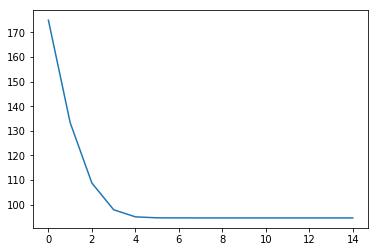

In [16]:
plt.plot(history.history['loss'])
plt.show()

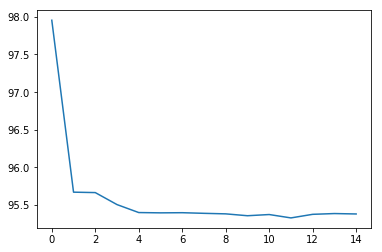

In [28]:
plt.plot(ctrhistory.history['loss'])
plt.show()

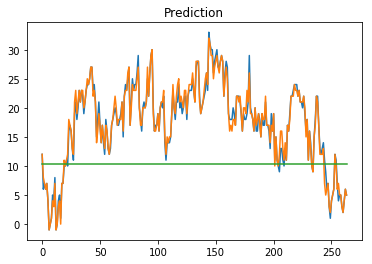

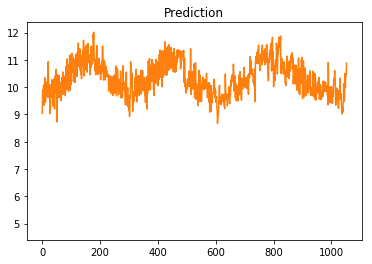

[10.394109 10.394109 10.394109 10.394109 10.394109 10.394109 10.394109
 10.394109 10.394109 10.394109]


In [46]:
plt.plot(Y_test[::48])
plt.plot(pred[::48])
plt.title('Prediction')
plt.show()


Y_mod= np.divide(Y_train[0:48,0], X_train[1:49,0])
plt.plot(Y_mod[::48])
plt.plot(predctr[::48])
plt.title('Prediction')
plt.show()

print(pred[:10])

In [ ]:
c = []

for i in range(len(Y_test)):
    c.append(abs(pred[i] - Y_test[i]))
    
plt.plot(c[::48])
plt.plot(Y_test[::48])
plt.title('Absolute error')
plt.show()

In [ ]:
# import re
# import pandas as pd
# import numpy as np
# from sklearn import preprocessing

# df = pd.read_csv('modified_dataset.csv', dtype={'Temperature':str, 'Pressure0':str, 'Humidity':str, 'Wind_speed':str}, delimiter=';', na_filter=False)

# from sklearn.externals import joblib
# scaler_filename = "scaler.save"
# scaler = joblib.load(scaler_filename) 


# array_test = []
# phenomena = ['mist', '', 'snow', 'rain', 'fog', 'shower', 'drizzle', 'squall', 'thunderstorm', 'hail']

# df_test = pd.read_csv('test.csv', dtype={'Temperature':str, 'Pressure0':str, 'Humidity':str, 'Wind_speed':str}, delimiter=',',skipinitialspace=True,  na_filter=False)
# exp = '[rR]ain|[fF]og|[tT]hunderstorm|[sS]now|[hH]ail|[mM]ist|[Ss]hower|[Dd]rizzle|[Ss]quall'
# exp_wind = '(Wind blowing from the )|( wind direction)|(Calm, )'
# l = 0
# for idx in df_test.index:
#     df_test.at[idx, 'Wind_direction'] = re.sub(exp_wind, '', df_test.at[idx, 'Wind_direction'])
#     df_test.at[idx, 'Phenomena'] = (', '.join(re.findall(exp, df_test.at[idx, 'Phenomena']))).lower()
#     df_test.at[idx, 'Cloud'] = df_test.at[idx, 'Cloud'].split(' (')[0].split('Vertical')[0].lower()

# for word in phenomena:
#     array_test.append([])
#     for line in df_test['Phenomena']:
#         separated = line.replace(" ", "").split(',')
#         if word in separated:
#             array_test[l].append(1)
#         else:
#             array_test[l].append(0)
#     l+=1
        
# for l in range(len(array_test)):
#     df_test[phenomena[l]] = array_test[l]

# df_test = df_test.drop('Phenomena', axis=1)



# df_test = pd.get_dummies(df_test, columns=["Wind_direction","Cloud"])

# arr = np.zeros(len(df_test))


# for column in df:
#     if column not in df_test:
#         df_test[column] = arr
        
# columnsTitles = df.columns.values
# df_test = df_test.reindex(columns=columnsTitles)

# df_test.to_csv (r'modified_testset.csv', index = None, header=True, sep=';')

In [ ]:
XPRED = np.array(df_test.loc[:, (df_test.columns != 'Time')].values)
YPRED = np.array(df_test['Temperature'])

XPRED = XPRED[:-1]
YPRED = YPRED[1:]

    
for idx, val in enumerate(XPRED[:,0]):
    if val=='':
        XPRED[:,0][idx] = (np.float64(XPRED[:,0][idx-1])+np.float64(XPRED[:,0][idx+1]))/2
    else:
        XPRED[:,0][idx] = np.float64(val)

for idx, val in enumerate(XPRED[:,1]):
    if val=='':
        XPRED[:,1][idx] = (np.float64(XPRED[:,1][idx-1])+np.float64(XPRED[:,1][idx+1]))/2
    else:
        XPRED[:,1][idx] = np.float64(val)


for idx, val in enumerate(XPRED[:,2]):
    if val=='':
        XPRED[:,2][idx] = (int(XPRED[:,2][idx-1])+int(XPRED[:,2][idx+1]))/2
    else:
        XPRED[:,2][idx] = int(val)

for idx, val in enumerate(XPRED[:,4]):
    if val=='':
        XPRED[:,4][idx] = (int(XPRED[:,4][idx-1])+int(XPRED[:,4][idx+1]))/2
    else:
        XPRED[:,4][idx] = int(val)

#print(YPRED[0])

XPRED = scaler.transform(XPRED)

In [ ]:
eredmeny = estimator.predict(XPRED)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(eredmeny)
plt.plot(YPRED)
plt.title('Prediction')
plt.show()

In [ ]:
for i in range (len(eredmeny)):
    print("predicted: ", "%.1f"%eredmeny[i], " real: " ,YPRED[i])